In [1]:
from sys import path as syspath
from pathlib import Path

syspath.append(str(Path().home() / "CarbonLab" / "reflutils"/"src"))

import reflutils as ru
import numpy as np

from pypxr.structure import *
from pypxr.reflectivity import *

import seaborn as sns
import matplotlib.pyplot as plt
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective
from refnx._lib.emcee.moves.de import *
import pandas as pd
import pickle
import periodictable.xsf as xsf

sns.set_context("paper", font_scale=1.5)
sns.set_theme(
    rc={"figure.figsize": (10, 5), "axes.xmargin": 0.01, "axes.ymargin": 0.01}
)
sns.set_palette("coolwarm")

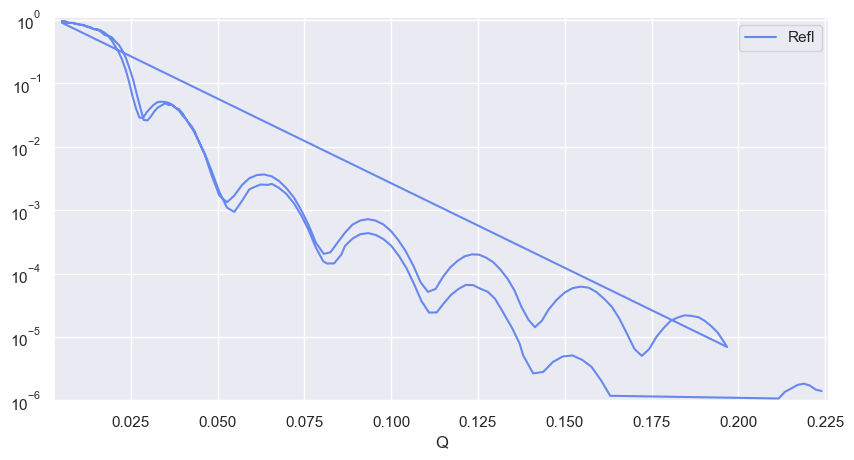

In [2]:
def hdh_path():
    path = (
        Path.home()
        / "Washington State University (email.wsu.edu)"
        / "Carbon Lab Research Group - Documents"
    )
    hdh_path = path / next(path.glob("*Harlan Heilman*"))
    csv = hdh_path / ".refl" / ".csv"
    return csv


d_path = hdh_path()


def ensure_nromalized(refl):
    refl.Refl = refl.Refl / refl.Refl.iloc[0]
    return refl


def to_refnx_dataset(refl, restat=True):
    refl = ensure_nromalized(refl)
    if restat:
        data = (refl.Q, refl.Refl, refl.Refl * 0.1)
    else:
        data = (refl.Q, refl.Refl, refl.Err)
    return ReflectDataset(data)


zrt_rt = pd.concat(
    [
        pd.read_csv(d_path / "zrt_250.0_100.csv", index_col=0),
        pd.read_csv(d_path / "zrt_250.0_190.csv", index_col=0),
    ]
)

zrt_rt = zrt_rt[zrt_rt.Q > 0.005]
zrt_rt = zrt_rt[zrt_rt.Refl > 1e-6]
fig, ax = plt.subplots()
zrt_rt.plot(x="Q", y="Refl", ax=ax, logy=True)

znpc_data = to_refnx_dataset(zrt_rt)

# Oriented Optical Constants From DFT

,Transition Energy (eV),Transition Amplitude (a.u.),Transition Width (eV),TDM_x,TDM_y,TDM_z,TDM Theta (degrees),Transition Symmetry,TDM_xx,TDM_yy,TDM_zz,TDM_xy,TDM_xz,TDM_yz,Originating atom,Originating MO
0,284.68234,0.027144,0.223871,0.022457,0.022457,2.999832,0.004530,1,1.510299e-06,1.510299e-06,0.027013,0,0,0,2,119
1,285.20261,0.008377,0.225601,0.030391,0.030391,3.999769,0.004443,1,4.587944e-07,4.587944e-07,0.008367,0,0,0,1,119
2,286.24313,0.011212,0.213482,0.015321,0.015321,1.999883,0.004756,1,6.557800e-07,6.557800e-07,0.011173,0,0,0,4,124
3,286.72336,0.005778,0.215778,1.420645,1.420645,1.015793,16.764746,1,8.595939e-04,8.595939e-04,0.004035,0,0,0,1,124
4,287.64383,0.001125,0.213177,0.007755,0.007755,0.999940,0.004873,1,6.734356e-08,6.734356e-08,0.001120,0,0,0,2,133
5,289.16458,0.002187,0.292297,0.012963,0.012963,1.999914,0.003323,1,8.940416e-08,8.940416e-08,0.002180,0,0,0,2,171
6,290.16507,0.015289,0.454604,0.052309,0.052309,6.999338,0.008111,1,1.530749e-06,1.530749e-06,0.015291,0,0,0,2,191
7,291.64581,0.020528,0.728375,10.605230,10.605230,0.185568,89.981560,1,1.031344e-02,1.031344e-02,0.000005,0,0,0,1,209
8,293.56677,0.014933,1.149679,6.427237,6.427237,3.148559,48.915871,1,4.667293e-03,4.667293e-03,0.005755,0,0,0,3,249
9,297.76889,0.076417,2.023586,29.610764,29.610764,11.688268,71.161148,1,3.116865e-02,3.116865e-02,0.015039,0,0,0,4,325


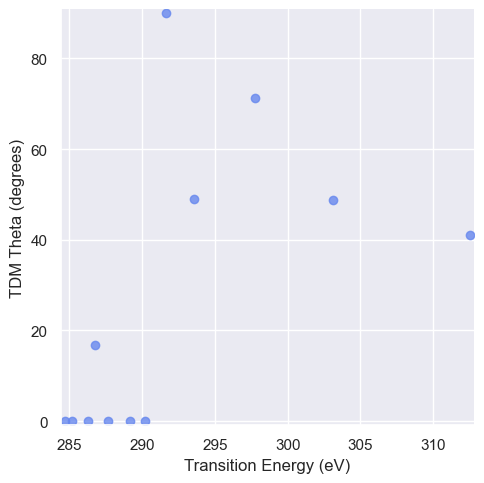

In [17]:
class DftDataFrame(pd.DataFrame):
    cols = [
         "Transition Energy (eV)",
         "Transition Amplitude (a.u.)",
         "Transition Width (eV)",
         "TDM_x",
         "TDM_y",
         "TDM_z",
         "TDM Theta (degrees)",
         "Transition Symmetry",
         "TDM_xx",
         "TDM_yy",
         "TDM_zz",
         "TDM_xy",
         "TDM_xz",
         "TDM_yz",
         "Originating atom",
         "Originating MO",
        #  "Final Cluster transition was placed in",
        ]
    def __init__(self, filepath):
        super().__init__()
        df = pd.read_csv(filepath, skiprows=1)
        df.columns = self.cols
        self.__dict__.update(df.__dict__)


dft = DftDataFrame(d_path / "allParamsSorted.txt")
sns.lmplot(data = dft, palette="pastel", x = "Transition Energy (eV)", y = "TDM Theta (degrees)", fit_reg=False)
dft

Index(['Energy 90', 'Energy 70', 'Energy 55', 'Energy 40', 'Energy 20',
       'NEXAFS 90', 'NEXAFS 70', 'NEXAFS 55', 'NEXAFS 40', 'NEXAFS 20'],
      dtype='object')


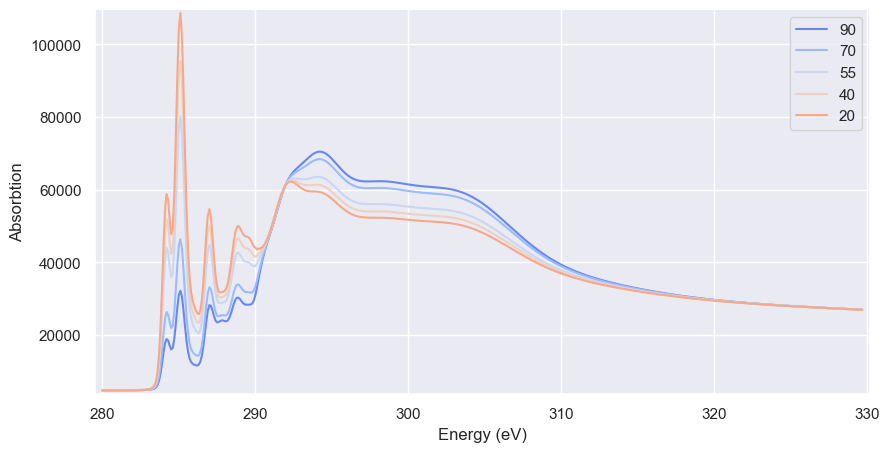

In [18]:
dft = pd.read_csv(d_path / "dft_res.txt")
cols = dft.columns
en_cols = [col for col in cols if "Energy" in col]
fit_cols = [col for col in cols if "fitresults" in col]
angles = ["90", "70", "55", "40", "20"]

dft = dft.iloc[1:-2]

fig, ax = plt.subplots(figsize=(10, 5))
for i, (en, fit) in enumerate(zip(en_cols, fit_cols)):
    dft.plot(x=en, y=fit, ax=ax, label=angles[i])
    dft.rename(
        columns={en: f"Energy {angles[i]}", fit: f"NEXAFS {angles[i]}"}, inplace=True
    )
ax.set(xlabel="Energy (eV)", ylabel="Absorbtion")
new_cols = dft.columns
print(new_cols)

[Text(0.5, 0, 'Energy (eV)'), Text(0, 0.5, 'Absorbtion')]

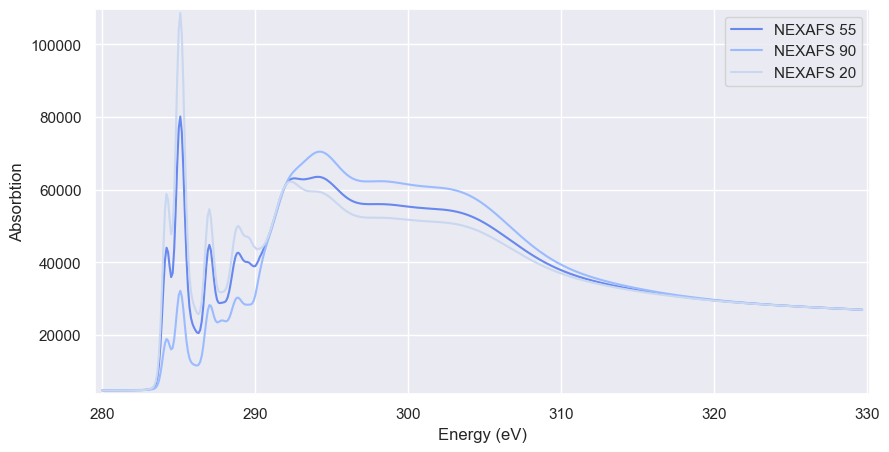

In [19]:
isotropic = dft[[new_cols[2], new_cols[7]]]
min_ang = dft[[new_cols[0], new_cols[5]]]
max_ang = dft[[new_cols[4], new_cols[-1]]]

fig, ax = plt.subplots()
isotropic.plot(x=new_cols[2], y=new_cols[7], ax=ax)
min_ang.plot(x=new_cols[0], y=new_cols[5], ax=ax)
max_ang.plot(x=new_cols[4], y=new_cols[-1], ax=ax)

ax.set(xlabel="Energy (eV)", ylabel="Absorbtion")

In [20]:
en = [250, 283.7]


def get_delta_beta(n):
    delta = 1 - n.real
    beta = -n.imag
    return delta + 1j * beta


_n_znpc = xsf.index_of_refraction(
    "C32H16N8Zn", density=2.2, energy=[e * 1e-3 for e in en]
)
n_znpc = get_delta_beta(_n_znpc)
print(f"The isotropic refractive index of ZnPc is {n_znpc}")

The isotropic refractive index of ZnPc is [ 0.00433637+0.00053227j -0.00068282+0.00035065j]


(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

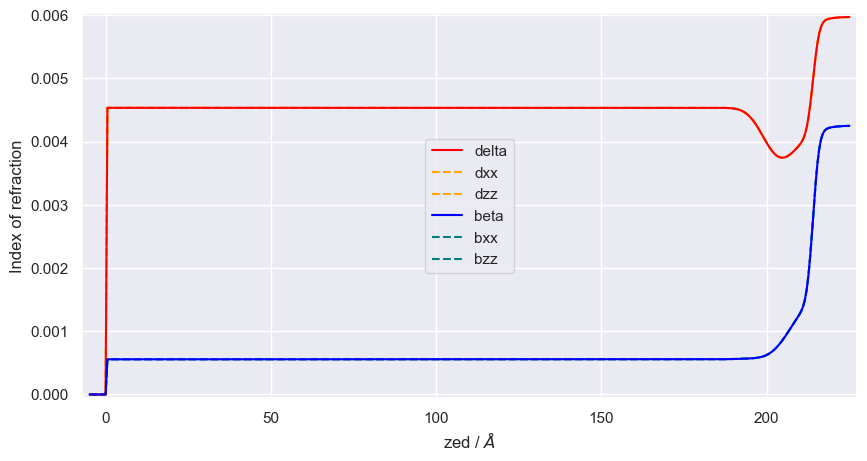

In [ ]:
""" 
Parameter Constraints
"""

max_thick = 300
max_rough = 10

sio2_t = 8.000003
sio2_rough = 6.38308
sio2_rho = 1.62331

carbon_thick = 6.08467
carbon_rough = 4.40733

znpc_thick = 200
znpc_rough = 0

vac = [PXR_MaterialSLD("", 1)(0, 0) for e in en]
si = [PXR_MaterialSLD("Si", 2.33, energy=en, name="Si")(0, 1.5) for e in en]
sio2 = [PXR_MaterialSLD("SiO2", sio2_rho, name="SiO2")(sio2_t, sio2_rough) for e in en]
carbon = [PXR_MaterialSLD("C", 1.8, name="Carbon")(carbon_thick, carbon_rough) for e in en]

znpc = [PXR_MaterialSLD("C32H16N8Zn", 2.3, energy=e, name="ZnPc")(
    znpc_thick, znpc_rough
) for e in en]

structure = vac | znpc | carbon | sio2 | si

structure.plot()

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

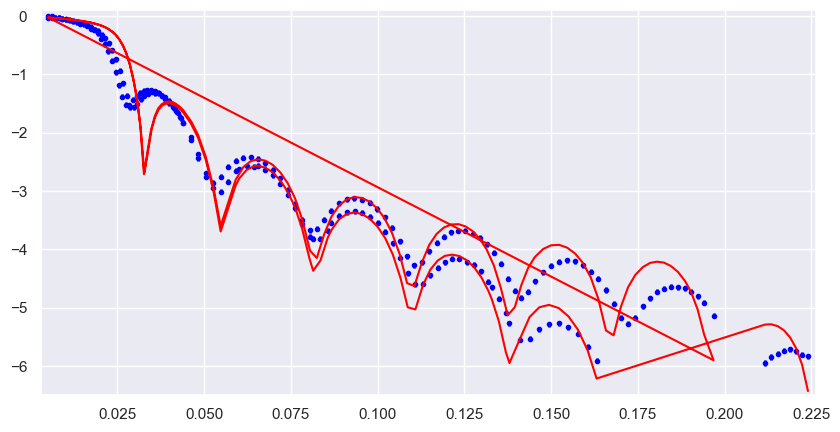

In [ ]:
from Logp import LogpExtra_rough

scale_vary = False
scale_lb = 0.6
scale_ub = 1.2

bkg_vary = False
bkg_lb = 1e-9
bkg_ub = 9e-6

random_state = 1
nwalkers = 100
nsamples = 200

move = [(DEMove(sigma=1e-7), 0.95), (DEMove(sigma=1e-7), 0.05)]
chain_name = "znpc_room_temp.txt"
save_fitter = "znpc_room_temp_fitter.pkl"

model = PXR_ReflectModel(
    structure, scale=1, bkg=0, dq=0, energy=en, pol="sp", name=f"ZnPc_{en}"
)

model.scale.setp(vary=scale_vary, bounds=(scale_lb, scale_ub))
model.bkg.setp(vary=bkg_vary, bounds=(bkg_lb, bkg_ub))

objective = Objective(model, znpc_data, transform=Transform("logY"), name=f"obj_{en}")
lpe = LogpExtra_rough(objective)
objective.logp_extra = lpe
objective.plot()

In [ ]:
sio2.thick.setp(vary=False)
sio2.rough.setp(vary=False)

carbon.thick.setp(vary=False)
carbon.rough.setp(vary=False)
carbon.sld.density.setp(vary=True, bounds=(1.5, 2))

znpc.thick.setp(vary=True, bounds=(max_thick / 2, max_thick))
znpc.rough.setp(vary=True, bounds=(0, max_rough))
znpc.sld.density.setp(vary=True, bounds=(1.5, 3))

100%|██████████| 2000/2000 [01:58<00:00, 16.91it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter: 'ZnPc_thick'  , value=196.441 +/- 0.132, bounds=[150.0, 300.0]>
<Parameter:     'rho'     , value=1.50014 +/- 0.00018, bounds=[1.5, 3.0]>
<Parameter: 'ZnPc_rough'  , value=7.21628 +/- 0.127, bounds=[0.0, 10.0]>
<Parameter:     'rho'     , value=1.64271 +/- 0.0672, bounds=[1.5, 2.0]>


(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

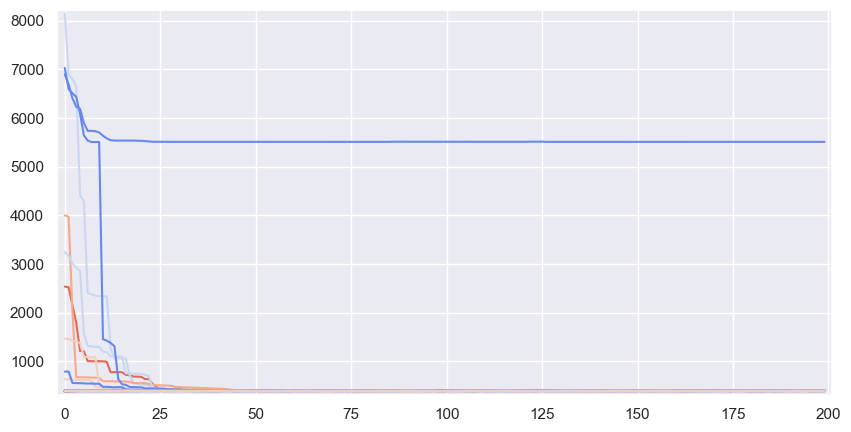

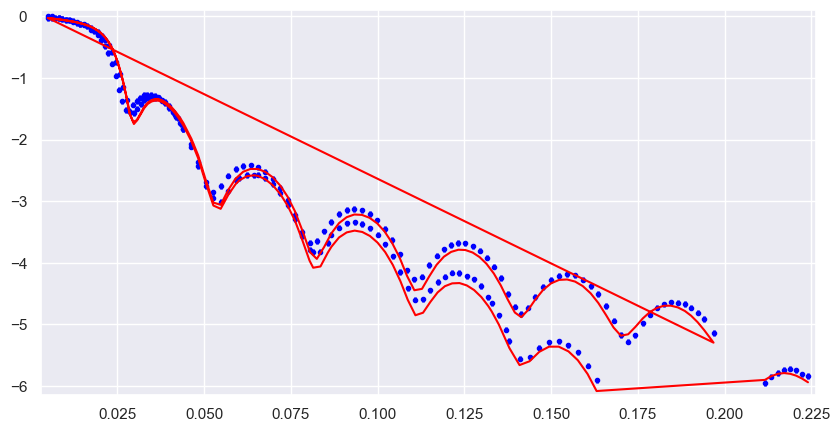

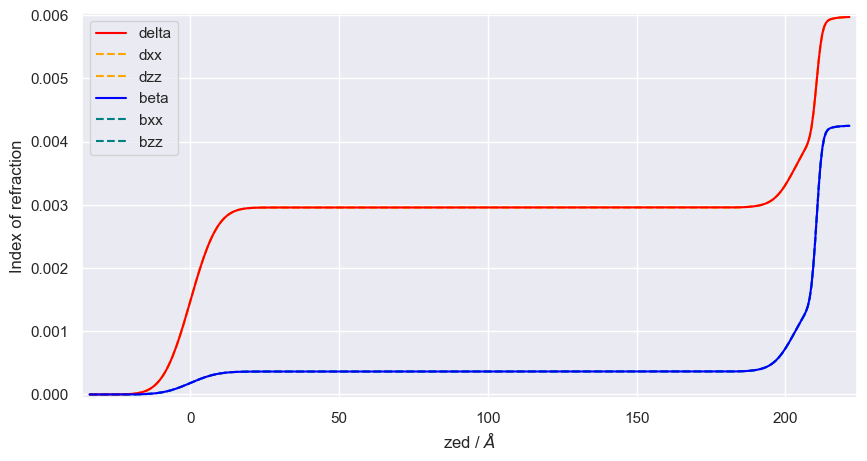

In [ ]:
fitter = CurveFitter(objective, nwalkers=nwalkers, moves=move)
fitter.initialise("jitter")
chain = fitter.sample(int(nsamples), nthin=10, random_state=random_state)
lp = fitter.logpost
plt.plot(-lp, yscale = "log")

print(objective.varying_parameters())
objective.plot()
structure.plot()

In [85]:
with open(d_path / save_fitter, "wb") as f:
    pickle.dump(fitter, f)

with open(d_path / chain_name, "wb") as f:
    f.write(str(objective.parameters).encode())

# Multi Energy Fitting

Error plotting BareSi 250.0 100
Error plotting C60-ZnPc 250.0 100
Error plotting C60-ZnPc 250.0 100
Error plotting C60-ZnPc 250.0 100
Error plotting C60-ZnPc 250.0 100
Error plotting C60-ZnPc 283.7 100
Error plotting C60-ZnPc 284.0 100


KeyboardInterrupt: 

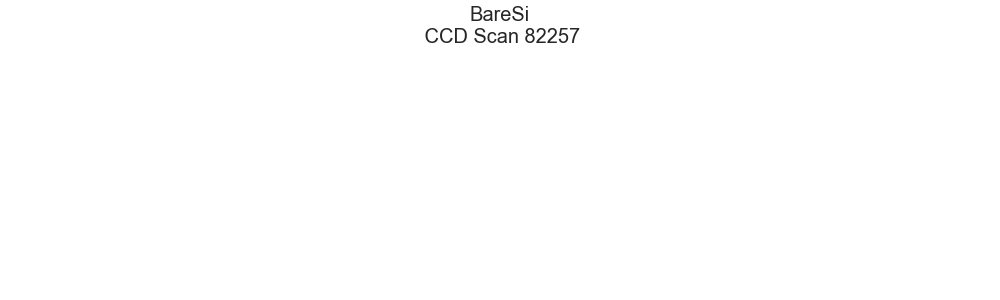

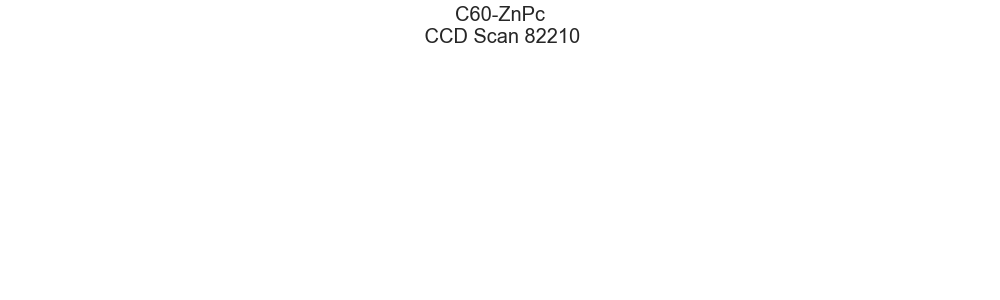

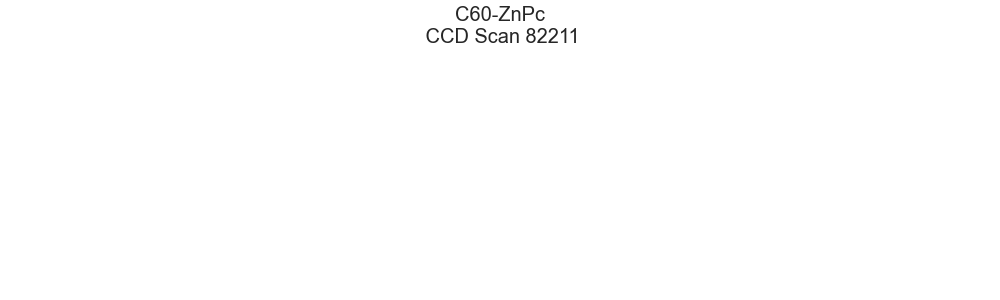

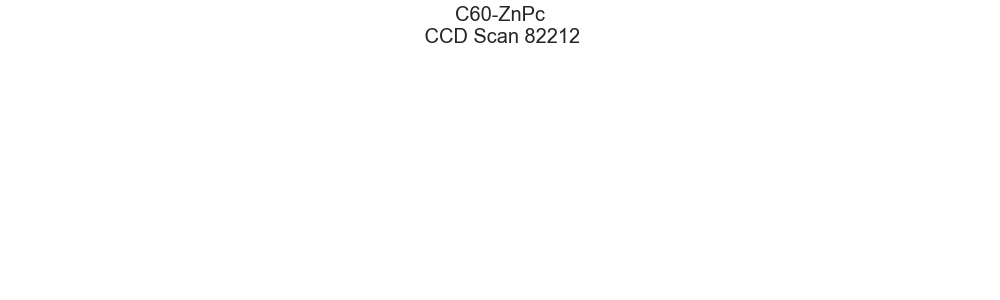

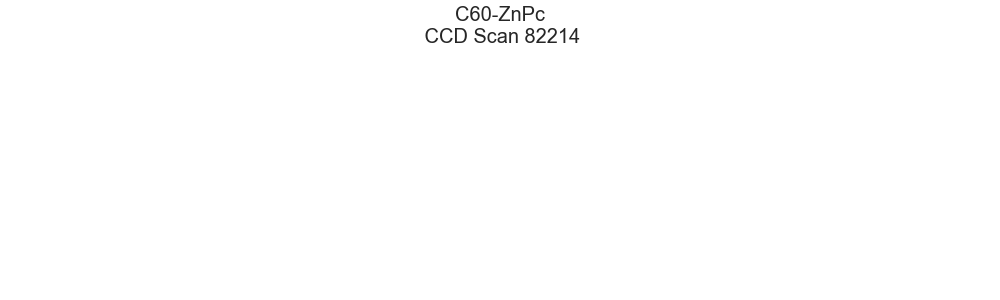

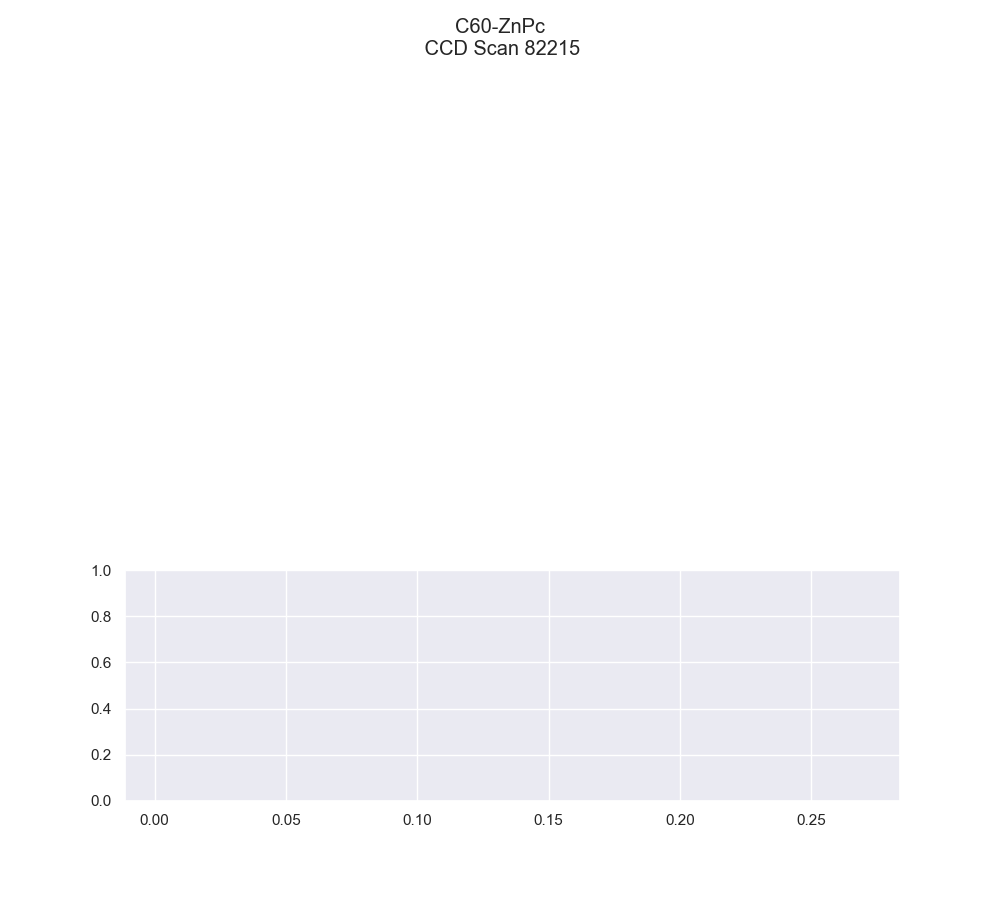

In [3]:
# def plot_sample(sample_path):
#     for scan in sample_path.iterdir():
#         if not scan.is_dir():
#             continue
#         energies = [en for en in scan.iterdir() if en.is_dir()]
#         fig, ax = plt.subplots(
#             nrows=len(energies),
#             figsize=(10, 3 * len(energies)),
#             sharex=True,
#             gridspec_kw={"wspace": 0, "hspace": 0},
#         )
#         fig.suptitle(f"{sample_path.stem}\n {scan.stem}")
#         for i, en in enumerate(energies):
#             if not en.is_dir():
#                 continue
#             for pol in en.iterdir():
#                 if not pol.is_dir():
#                     continue
#                 if isinstance(ax, np.ndarray):
#                     axes = ax[i]
#                 else:
#                     axes = ax
#                 try:
#                     xrr = ru.Refl(path=pol)
#                     xrr.plot(ax=axes, label=f"{en.name} {pol.stem}")
#                     xrr.to_parquet()
#                     xrr.to_csv()
#                 except Exception as e:
#                     print(f"Error plotting {sample_path.stem} {en.name} {pol.stem}")
#                     axes.remove()


# import warnings

# warnings.filterwarnings("ignore")


# # FILEPATH: /c:/Users/Harlan Heilman/CarbonLab/Refl-Utils/src/RoomTempFitting.ipynb
# def plot_bt():
#     processed_path = ru.FileDialog.getDirectory(title="Select Processed Directory")
#     samples = [s for s in processed_path.iterdir() if s.is_dir()]
#     for sample in samples:
#         plot_sample(sample)


# plot_bt()